[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ASKabalan/jax-hpc-profiler/blob/main/examples/distributed_profiling.ipynb)

### **Distributed Profiling with JAX HPC Profiler**

This notebook demonstrates how to use the `jax_hpc_profiler` package for distributed profiling in a multi-device setup. By utilizing environment variables to configure JAX for multi-device execution, we can simulate distributed environments and gather performance data for analysis. The notebook walks through setting up profiling for large-scale computations, capturing performance metrics, and generating visualizations for scalability analysis.

In [1]:
try:
    import google.colab

    !pip install -q jax-hpc-profiler 
except ImportError:
    pass  # Not in Colab

In [2]:
import os

os.environ['JAX_PLATFORM_NAME'] = 'cpu'
os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=32'
import jax
import jax.numpy as jnp

from jax_hpc_profiler import JaxTimer

OUTPUT_PATH = 'jax_hpc_profiler_report'

In this section, a JAX function mma is defined to perform matrix multiplication and addition, optimized using the JIT compiler.

In [3]:
# Define JAX functions
@jax.jit
def mma(m, n, k):
    return jnp.dot(m, n) + k

### **Distributed Profiling with Multiple Devices**

This section demonstrates profiling on multiple devices (using 4, 8, 16, and 32 devices) in a distributed JAX setup, where matrices are sharded across the devices for parallel computation. The performance is then measured and reported for different matrix sizes.

In [4]:
from jax import lax
from jax.sharding import AxisType, NamedSharding
from jax.sharding import PartitionSpec as P

for n_devices in [4, 8, 16, 32]:
    devices = jax.devices()[:n_devices]
    timer = JaxTimer(devices=devices)
    mesh = jax.make_mesh((len(devices),), ('x',), devices=devices, axis_types=(AxisType.Auto,))
    sharding = NamedSharding(mesh, P('x'))

    for size in [128, 256, 512, 1024]:
        # JAX Matrices
        m_jax = jnp.ones((size, size))
        n_jax = jnp.ones((size, size))
        k_jax = jnp.ones((size, size))

        # JAX Sharded Matrices
        m_jax = lax.with_sharding_constraint(m_jax, sharding)
        n_jax = lax.with_sharding_constraint(n_jax, sharding)
        k_jax = lax.with_sharding_constraint(k_jax, sharding)

        timer.chrono_jit(mma, m_jax, n_jax, k_jax)
        for _ in range(10):
            timer.chrono_fun(mma, m_jax, n_jax, k_jax)

        kwargs = {
            'function': 'mma',
            'precision': 'float32',
            'x': size,
            'y': size,
            'px': n_devices,
            'py': 1,
        }
        extra_info = {'done': 'yes'}
        timer.report(f'{OUTPUT_PATH}/JAX_MULTI.csv', **kwargs, extra_info=extra_info)

### **Visualizing Scaling with `plot_by_gpus` and `plot_by_data_size`**

This section uses multi-device results in `JAX_MULTI.csv` to create scaling plots:
- **`plot_by_gpus`**: subplots per GPU count, x-axis = data size.
- **`plot_by_data_size`**: subplots per data size, x-axis = GPUs (strong scaling view).
- **`probe_csv_metadata`**: inspect what data sizes, GPU counts, and other metadata are available in a CSV.


In [5]:
import os
import sys

import matplotlib.pyplot as plt
import seaborn as sns

for rel in ('src', os.path.join('..', 'src')):
    path = os.path.abspath(rel)
    if os.path.isdir(path) and path not in sys.path:
        sys.path.insert(0, path)

from jax_hpc_profiler.plotting import plot_by_data_size, plot_by_gpus
from jax_hpc_profiler.utils import probe_csv_metadata

plt.rcParams.update({'font.size': 15})
sns.set_context('talk')

csv_file = [f'{OUTPUT_PATH}/JAX_MULTI.csv']

#### `plot_by_gpus` — Subplots per GPU Count

This plot shows how runtime changes as the **problem size increases** while keeping the **number of GPUs constant** (one subplot per GPU count, x-axis = data size). This helps understand the computational overhead and memory bandwidth limitations at different scales.

requested GPUS: None available GPUS: {np.int64(8), np.int64(16), np.int64(32), np.int64(4)}

        requested data sizes: None
        available global volumes: {np.int64(2097152), np.int64(16777216), np.int64(134217728), np.int64(1073741824)}
        


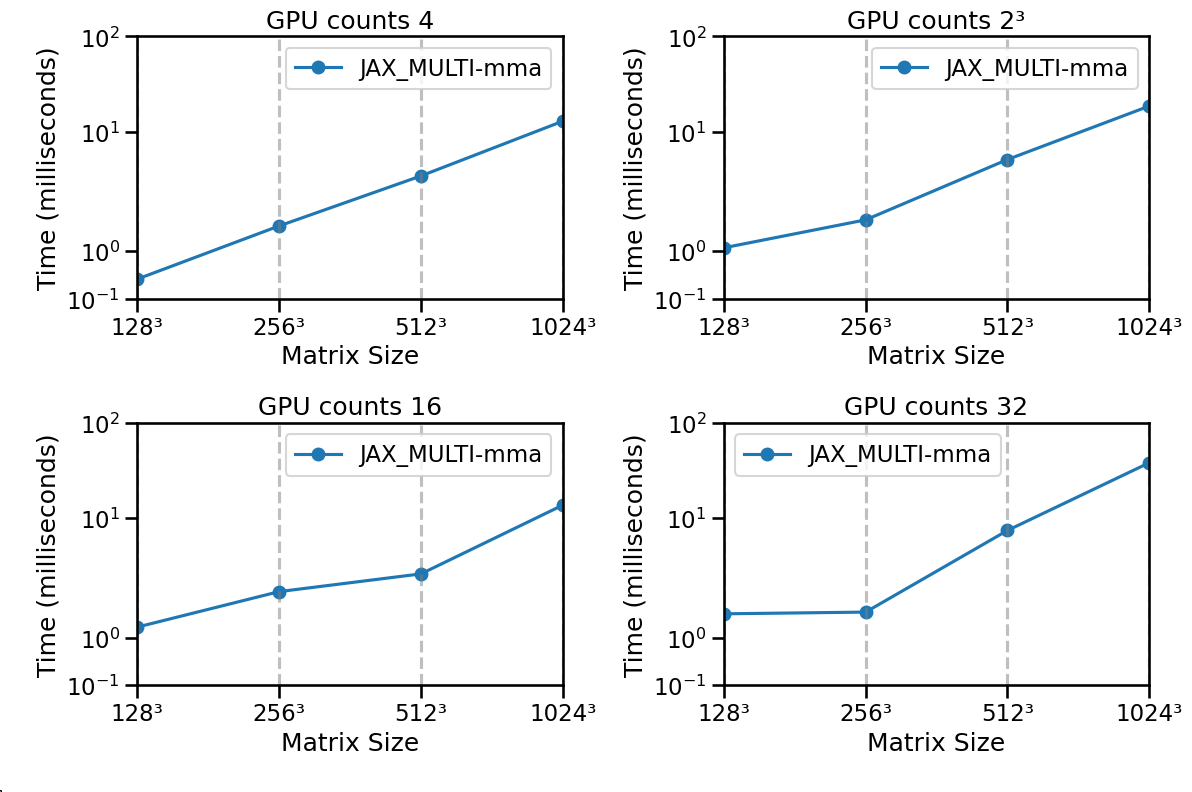

In [6]:
plot_by_gpus(
    csv_files=csv_file,
    figure_size=(12, 8),
    label_text='%m%-%f%',
    xlabel='Matrix Size',
    xscale='log2',
)

#### `plot_by_data_size` — Subplots per Data Size

This plot shows how runtime decreases when **adding more GPUs** to a **fixed problem size** (one subplot per data size, x-axis = GPUs). This reveals parallelization efficiency — ideal strong scaling would show runtime halving when doubling the number of GPUs. Deviations indicate communication overhead or load imbalance.

requested GPUS: None available GPUS: {np.int64(8), np.int64(16), np.int64(32), np.int64(4)}

        requested data sizes: None
        available global volumes: {np.int64(2097152), np.int64(16777216), np.int64(134217728), np.int64(1073741824)}
        


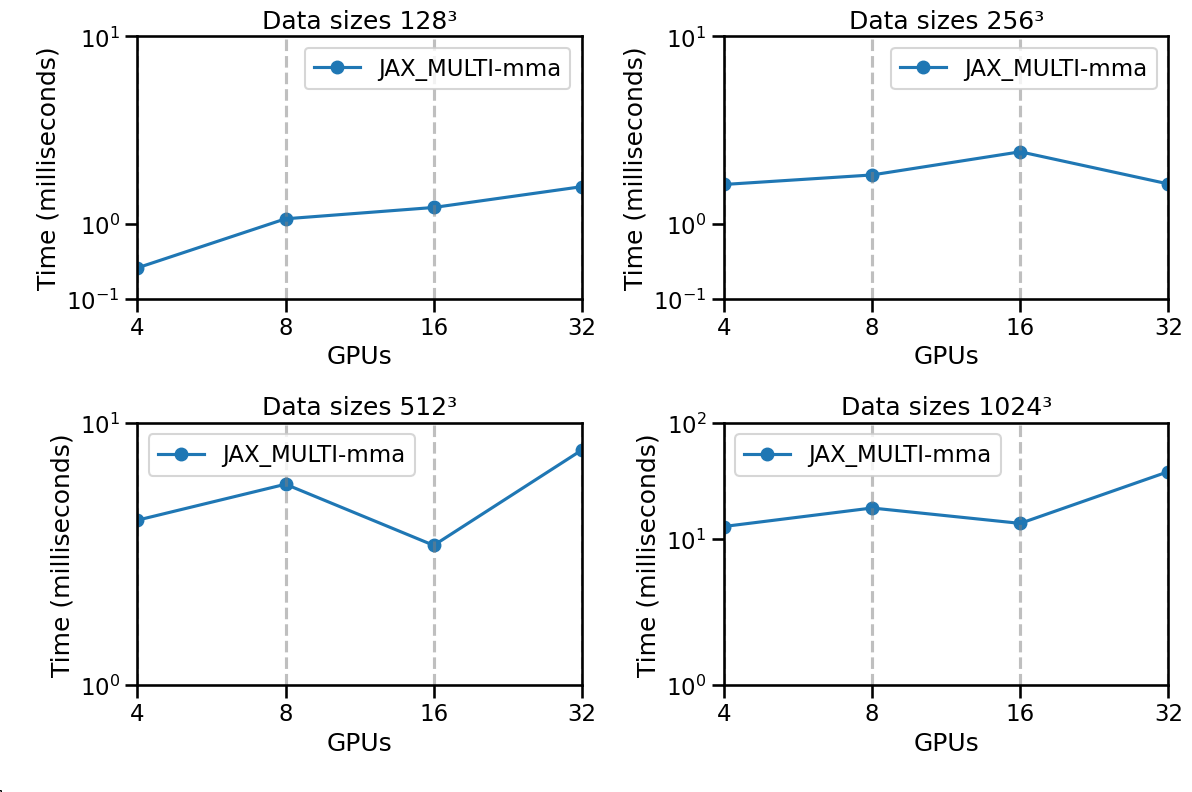

In [7]:
plot_by_data_size(
    csv_files=csv_file,
    figure_size=(12, 8),
    label_text='%m%-%f%',
    xlabel='GPUs',
    xscale='log2',
)

#### `probe_csv_metadata` — Inspect Available Data

Use `probe_csv_metadata` to inspect what data sizes, GPU counts, functions, backends, and other metadata are available in your CSV files. This is helpful before plotting to understand what filters to apply.

In [8]:
print(probe_csv_metadata(csv_file))

=== CSV Probe Report ===

Files: JAX_MULTI.csv

Functions:  mma
Backends:   NCCL
Precisions: float32
GPU counts: 4, 8, 16, 32

Query Alias              Global Volume    Local Volume     GPUs Available       Shapes (X×Y×Z)      
------------------------------------------------------------------------------------------------
global_2097152           128³             —                4, 8, 16, 32         128×128×128         
global_16777216          256³             —                4, 8, 16, 32         256×256×256         
global_134217728         512³             —                4, 8, 16, 32         512×512×512         
global_1073741824        1024³            —                4, 8, 16, 32         1024×1024×1024      
local_65536              —                65,536           32                   128×128×128         
local_131072             —                131,072          16                   128×128×128         
local_262144             —                64³              8         

#### `plot_by_data_size` with Ideal Line

Use `ideal_line=True` to overlay an ideal scaling reference line. For subplots by global data size (strong scaling), the ideal line follows 1/N. You can also filter to specific data sizes using `data_size_queries`.

requested GPUS: None available GPUS: {np.int64(8), np.int64(16), np.int64(32), np.int64(4)}

        requested data sizes: ['global_128x128x128', 'global_256x256x256', 'global_512x512x512', 'global_1024x1024x1024']
        available global volumes: {np.int64(2097152), np.int64(16777216), np.int64(134217728), np.int64(1073741824)}
        


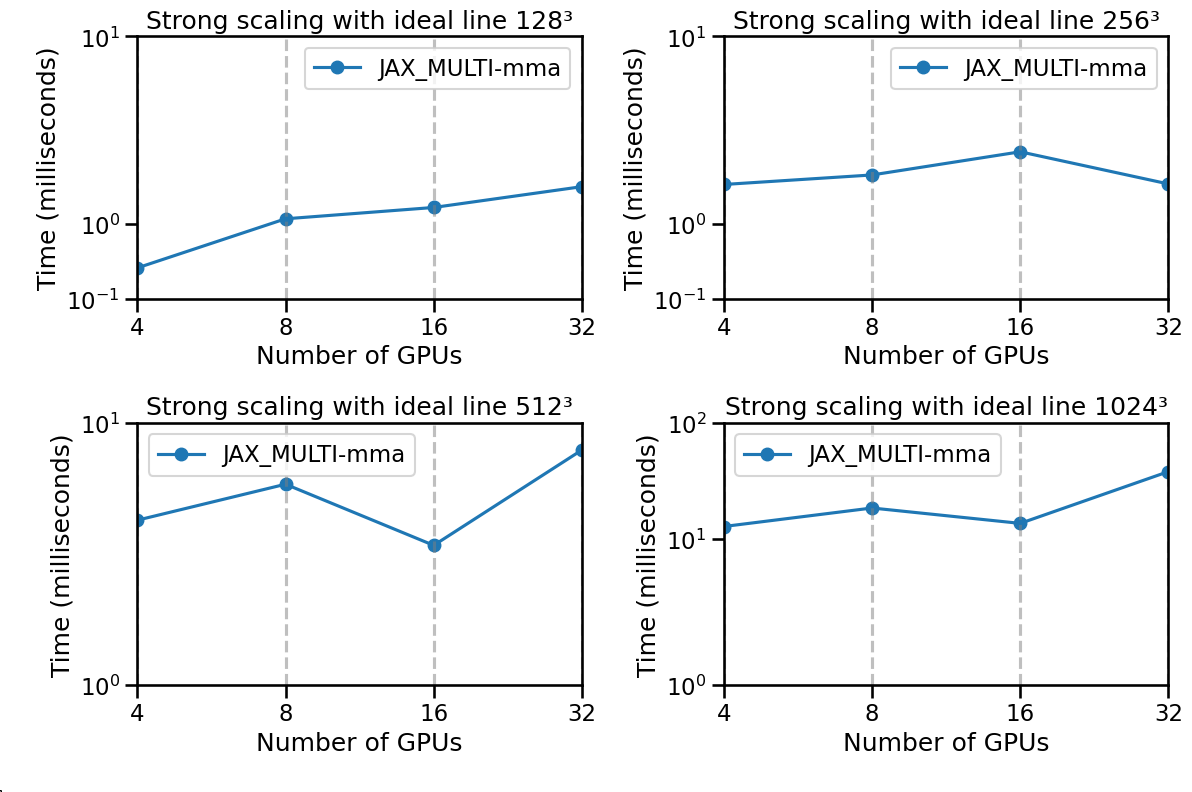

In [9]:
plot_by_data_size(
    csv_files=csv_file,
    data_size_queries=[
        'global_128x128x128',
        'global_256x256x256',
        'global_512x512x512',
        'global_1024x1024x1024',
    ],
    figure_size=(12, 8),
    label_text='%m%-%f%',
    xlabel='Number of GPUs',
    title='Strong scaling with ideal line',
    xscale='log2',
)

### **CLI examples**

Use `jhp plot` with `-sc data` or `-sc GPUs`.

- Subplots per data size, x-axis = GPUs (strong scaling view):

```bash
!jhp plot -f JAX_MULTI.csv -sc data -d 128 256 512 1024 -pt mean_time --ideal_line
```

- Subplots per GPU count, x-axis = data size:

```bash
!jhp plot -f JAX_MULTI.csv -sc GPUs -pt mean_time
```

- Inspect CSV metadata:

```bash
!jhp probe -f JAX_MULTI.csv
```
